In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.models import shufflenet_v2_x0_5

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'results/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('Shuffle Net Classifier. First Test.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] / 255.0
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

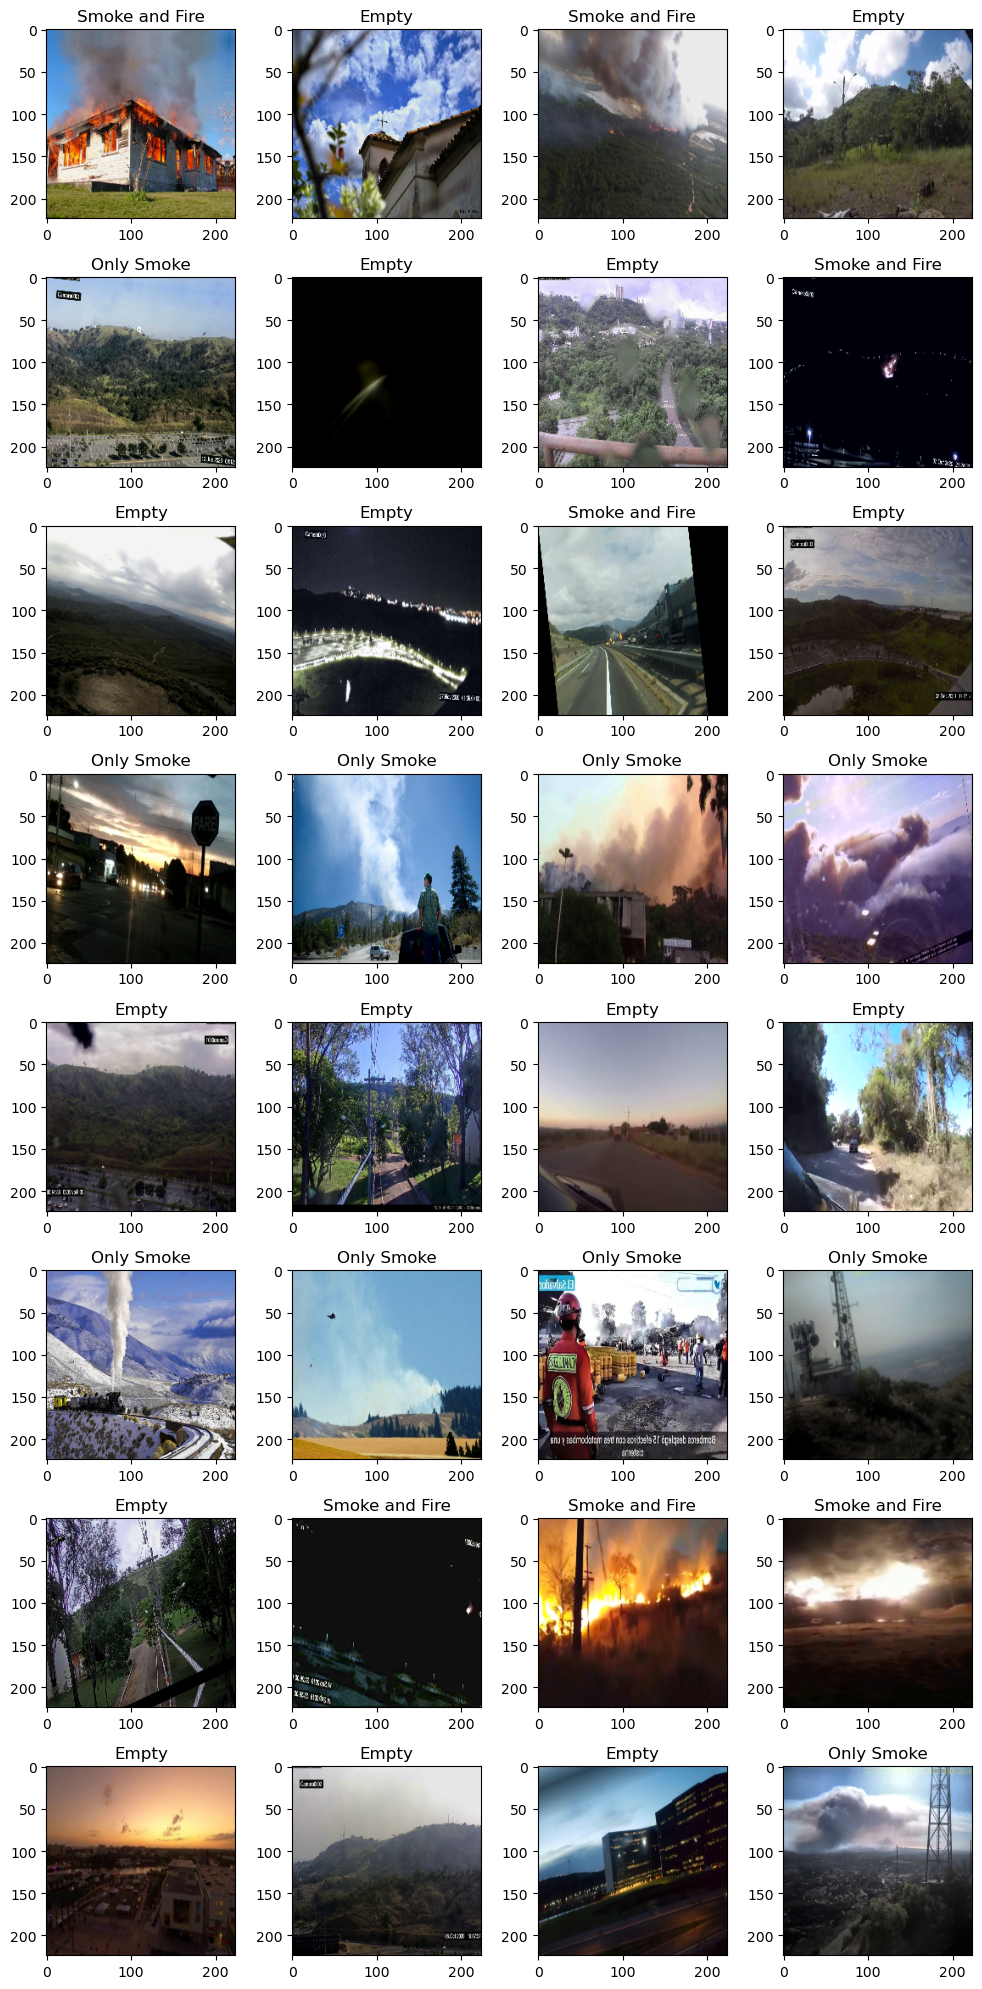

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: ShuffleNet Pretrained

In [10]:
class PRETRAINED_SHUFFLE(nn.Module):
    def __init__(self, base_model, last_channels, num_classes, in_channels=3):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.last_channels = last_channels
        
        self.base_model = nn.Sequential(*list(base_model.children())[:-1])

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )

    # TODO: initizalize only head layers
    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d):
    #             nn.init.kaiming_normal_(m.weight, mode='fan_in',
    #                 nonlinearity='relu'
    #             )
    #             if m.bias is not None:
    #                     nn.init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.Linear):
    #             nn.init.normal_(m.weight, 0, 0.01)
    #             nn.init.constant_(m.bias, 0)

    # [xc1, yc1, w1, h1, conf1, xc2, yc2, w2, h2, conf2, smoke, fire]
    # [0 ................. 4,    5 ................ 9      10    11 ]
    
    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #x = torch.sigmoid(x) # BCE Logits
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device):
        super(BCE_LOSS, self).__init__()
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.bce = nn.BCEWithLogitsLoss(reduction='sum')
        self.mse = nn.MSELoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce(predictions[..., 0],
                              ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce(predictions[..., 1],
                             ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [12]:
''' ============================
    Hyperparameters and More
============================ '''

#MODEL = "BED"
MODEL = "SHUFFLE"

#LEARNING_RATE = 5e-4
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-3
EPOCHS = 20 #100
NUM_WORKERS = 8
PIN_MEMORY = True
PRETRAINED = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + "bed_classifier_best.pt"
elif MODEL == "SQUEEZE":
    #LOAD_MODEL_FILE = log_path + "squeeze_classifier_best.pt"
    LOAD_MODEL_FILE = "squeezeNet/" + "SQUEEZE_best_classifier.pt"

LOSS_FN = "BCE"

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Model Setup

In [13]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''

def setup_model(pretrained, load, model_name):
    if pretrained == True:
        if model_name == "SHUFFLE":
            print("Using SHUFFLE Classifier")
            logger.info("Using SHUFFLE Classifier")
        
            base_model = shufflenet_v2_x0_5(weights='IMAGENET1K_V1')
            print(list(base_model.children())[-1])
            for name, layer in base_model.named_modules():
                if isinstance(layer, nn.Linear):
                    last_channels = layer.in_features
                    print(f'Model Pretrained has {last_channels} in features in last layer')
                    logger.info(f'Model Pretrained has {last_channels} in features in last layer')
            for param in base_model.parameters():
                param.requires_grad = False
            
            model = PRETRAINED_SHUFFLE(base_model, last_channels, num_classes=N_CLASSES).to(DEVICE)   

            return model
    else:
        print("Wrong Model")
        logger.info("Wrong Model")
        raise SystemExit("Wrong Model")

model = setup_model(pretrained=PRETRAINED, load=LOAD_MODEL, model_name=MODEL)

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using SHUFFLE Classifier
Linear(in_features=1024, out_features=1000, bias=True)
Model Pretrained has 1024 in features in last layer
Model shape is tensor([[ 0.0150, -0.0641],
        [ 0.0200, -0.0730],
        [ 0.0153, -0.0683],
        [ 0.0095, -0.0651]], device='cuda:0', grad_fn=<CatBackward0>)
BED Model Arquitecture
PRETRAINED_SHUFFLE(
  (base_model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 24

# Metrics

In [14]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [15]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [16]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [17]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Main Function

In [18]:
''' ============================
    Print Config Values
============================ '''
print(f'Device: {DEVICE}')
print(f'Learning Rate: {LEARNING_RATE}')
print(f'Weight Decay: {WEIGHT_DECAY}')
print(f'Batch Size: {BATCH_SIZE}')
print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
print(f'W: {IMG_W}\nH: {IMG_H}')

logger.info(f'Device: {DEVICE}')
logger.info(f'Learning Rate: {LEARNING_RATE}')
logger.info(f'Weight Decay: {WEIGHT_DECAY}')
logger.info(f'Batch Size: {BATCH_SIZE}')
logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
logger.info(f'W: {IMG_W}\nH: {IMG_H}')

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224


## Loss Funtion Setup

In [19]:
# LOSS FUNCTION
if LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'Loss Function: BCE')
    loss_fn = BCE_LOSS(device=DEVICE)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE


In [20]:
def train_model(model, model_name, optimizer, scheduler, epochs = EPOCHS):
   
    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if model_name == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif model_name == "SQUEEZE":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        else: 
            print("Pretrained Weights")
            logger.info("Pretrained Weights")            
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, epochs):

        print(f'\n=== EPOCH {epoch}/{epochs-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{epochs-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + model_name + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + model_name + '_best_classifier.pt')    
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + model_name + '_last_classifier.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [21]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    model_freeze = train_model(model=model, 
                               model_name=MODEL+'_FREEZE_',
                               optimizer=optimizer, 
                               scheduler=scheduler, 
                               epochs = EPOCHS)

Starting script


***Start Training: 22:46:09

Pretrained Weights

=== EPOCH 0/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
67.845      |40.503      |27.342      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.351      |36.542      |17.809      

SMOKE -> Precision: 0.729 - Recall: 0.681 - Accuracy: 0.725 - F1: 0.704
FIRE -> Precision: 0.830 - Recall: 0.765 - Accuracy: 0.899 - F1: 0.796

Saving model with new best validation loss: 54.351

=== EPOCH 1/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.820      |35.179      |17.641      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.782      |32.963      |14.819      

SMOKE -> Precision: 0.773 - Recall: 0.698 - Accuracy: 0.756 - F1: 0.733
FIRE -> Precision: 0.817 - Recall: 0.846 - Accuracy: 0.911 - F1: 0.831

Saving model with new best validation loss: 47.782

=== EPOCH 2/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 12.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.105      |33.219      |15.886      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.250      |31.207      |13.043      

SMOKE -> Precision: 0.764 - Recall: 0.765 - Accuracy: 0.773 - F1: 0.764
FIRE -> Precision: 0.861 - Recall: 0.817 - Accuracy: 0.919 - F1: 0.839

Saving model with new best validation loss: 44.250

=== EPOCH 3/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.648      |31.650      |14.998      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.064      |29.754      |12.310      

SMOKE -> Precision: 0.813 - Recall: 0.714 - Accuracy: 0.783 - F1: 0.760
FIRE -> Precision: 0.869 - Recall: 0.834 - Accuracy: 0.925 - F1: 0.851

Saving model with new best validation loss: 42.064

=== EPOCH 4/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.380      |30.978      |14.402      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.772      |28.794      |11.978      

SMOKE -> Precision: 0.804 - Recall: 0.754 - Accuracy: 0.793 - F1: 0.778
FIRE -> Precision: 0.866 - Recall: 0.870 - Accuracy: 0.931 - F1: 0.868

Saving model with new best validation loss: 40.772

=== EPOCH 5/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.852      |30.693      |14.159      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.542      |28.171      |11.371      

SMOKE -> Precision: 0.804 - Recall: 0.781 - Accuracy: 0.803 - F1: 0.793
FIRE -> Precision: 0.885 - Recall: 0.856 - Accuracy: 0.934 - F1: 0.870

Saving model with new best validation loss: 39.542

=== EPOCH 6/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.960      |29.973      |13.987      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.744      |27.647      |11.097      

SMOKE -> Precision: 0.816 - Recall: 0.768 - Accuracy: 0.805 - F1: 0.791
FIRE -> Precision: 0.897 - Recall: 0.846 - Accuracy: 0.935 - F1: 0.871

Saving model with new best validation loss: 38.744

=== EPOCH 7/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.310      |29.794      |13.516      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.880      |26.997      |10.883      

SMOKE -> Precision: 0.818 - Recall: 0.785 - Accuracy: 0.812 - F1: 0.801
FIRE -> Precision: 0.911 - Recall: 0.825 - Accuracy: 0.934 - F1: 0.866

Saving model with new best validation loss: 37.880

=== EPOCH 8/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.488      |29.183      |13.305      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.310      |26.731      |10.579      

SMOKE -> Precision: 0.824 - Recall: 0.773 - Accuracy: 0.811 - F1: 0.798
FIRE -> Precision: 0.909 - Recall: 0.848 - Accuracy: 0.939 - F1: 0.877

Saving model with new best validation loss: 37.310

=== EPOCH 9/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.144      |29.196      |12.948      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.226      |26.804      |10.422      

SMOKE -> Precision: 0.789 - Recall: 0.848 - Accuracy: 0.818 - F1: 0.817
FIRE -> Precision: 0.903 - Recall: 0.858 - Accuracy: 0.939 - F1: 0.880

Saving model with new best validation loss: 37.226

=== EPOCH 10/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.699      |28.808      |12.891      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.744      |26.450      |10.294      

SMOKE -> Precision: 0.879 - Recall: 0.714 - Accuracy: 0.815 - F1: 0.788
FIRE -> Precision: 0.918 - Recall: 0.840 - Accuracy: 0.939 - F1: 0.877

Saving model with new best validation loss: 36.744

=== EPOCH 11/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.224      |28.387      |12.836      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.884      |25.776      |10.108      

SMOKE -> Precision: 0.816 - Recall: 0.816 - Accuracy: 0.823 - F1: 0.816
FIRE -> Precision: 0.896 - Recall: 0.873 - Accuracy: 0.941 - F1: 0.884

Saving model with new best validation loss: 35.884

=== EPOCH 12/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.097      |28.132      |12.965      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.367      |25.372      |9.995       

SMOKE -> Precision: 0.832 - Recall: 0.788 - Accuracy: 0.821 - F1: 0.809
FIRE -> Precision: 0.910 - Recall: 0.860 - Accuracy: 0.942 - F1: 0.885

Saving model with new best validation loss: 35.367

=== EPOCH 13/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.030      |28.226      |12.804      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.931      |25.067      |9.863       

SMOKE -> Precision: 0.841 - Recall: 0.784 - Accuracy: 0.825 - F1: 0.812
FIRE -> Precision: 0.908 - Recall: 0.862 - Accuracy: 0.942 - F1: 0.884

Saving model with new best validation loss: 34.931

=== EPOCH 14/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.807      |28.125      |12.683      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.756      |24.824      |9.932       

SMOKE -> Precision: 0.849 - Recall: 0.781 - Accuracy: 0.828 - F1: 0.814
FIRE -> Precision: 0.899 - Recall: 0.880 - Accuracy: 0.943 - F1: 0.889

Saving model with new best validation loss: 34.756

=== EPOCH 15/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.594      |27.888      |12.706      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.469      |24.653      |9.817       

SMOKE -> Precision: 0.832 - Recall: 0.821 - Accuracy: 0.834 - F1: 0.826
FIRE -> Precision: 0.913 - Recall: 0.856 - Accuracy: 0.942 - F1: 0.884

Saving model with new best validation loss: 34.469

=== EPOCH 16/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.746      |28.022      |12.723      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.400      |24.614      |9.785       

SMOKE -> Precision: 0.852 - Recall: 0.779 - Accuracy: 0.829 - F1: 0.814
FIRE -> Precision: 0.912 - Recall: 0.862 - Accuracy: 0.943 - F1: 0.887

Saving model with new best validation loss: 34.400

=== EPOCH 17/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.472      |27.663      |12.808      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.112      |24.351      |9.761       

SMOKE -> Precision: 0.855 - Recall: 0.777 - Accuracy: 0.829 - F1: 0.814
FIRE -> Precision: 0.898 - Recall: 0.878 - Accuracy: 0.943 - F1: 0.888

Saving model with new best validation loss: 34.112

=== EPOCH 18/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.035      |27.360      |12.675      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.982      |24.172      |9.810       

SMOKE -> Precision: 0.832 - Recall: 0.835 - Accuracy: 0.839 - F1: 0.833
FIRE -> Precision: 0.898 - Recall: 0.883 - Accuracy: 0.944 - F1: 0.891

Saving model with new best validation loss: 33.982

=== EPOCH 19/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.725      |27.305      |12.420      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.780      |24.106      |9.674       

SMOKE -> Precision: 0.854 - Recall: 0.790 - Accuracy: 0.834 - F1: 0.821
FIRE -> Precision: 0.905 - Recall: 0.868 - Accuracy: 0.942 - F1: 0.886

Saving model with new best validation loss: 33.780

***Script finished: 22:54:53

Time elapsed: 0:08:44.485201


# Plot Results

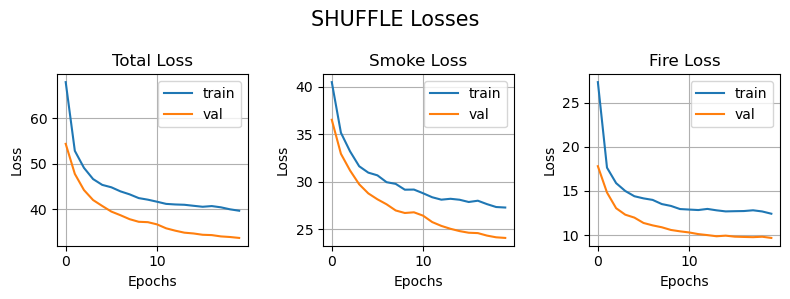

In [22]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle(MODEL + ' Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + MODEL + "_losses.png")
plt.show()

# Fine Tuning

In [23]:
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4
EPOCHS = 50 

In [24]:
for param in model_freeze.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model_freeze.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)
# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model_freeze.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model_freeze.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')


Trainable parameters = 374626
Total parameters = 374626



In [25]:
if __name__ == "__main__":
    print("Starting Fine Tuning\n")
    logger.info("Starting script\n")
    model_freeze = train_model(model=model_freeze, 
                               model_name=MODEL+'FineTune',
                               optimizer=optimizer, 
                               scheduler=scheduler, 
                               epochs = EPOCHS)

Starting Fine Tuning


***Start Training: 23:06:21

Pretrained Weights

=== EPOCH 0/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.843      |26.841      |12.001      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.535      |23.257      |9.278       

SMOKE -> Precision: 0.847 - Recall: 0.821 - Accuracy: 0.842 - F1: 0.834
FIRE -> Precision: 0.911 - Recall: 0.875 - Accuracy: 0.945 - F1: 0.892

Saving model with new best validation loss: 32.535

=== EPOCH 1/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.400      |26.412      |11.988      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.795      |22.741      |9.055       

SMOKE -> Precision: 0.855 - Recall: 0.830 - Accuracy: 0.851 - F1: 0.843
FIRE -> Precision: 0.908 - Recall: 0.894 - Accuracy: 0.949 - F1: 0.901

Saving model with new best validation loss: 31.795

=== EPOCH 2/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.914      |25.557      |11.356      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.140      |22.336      |8.804       

SMOKE -> Precision: 0.857 - Recall: 0.840 - Accuracy: 0.855 - F1: 0.848
FIRE -> Precision: 0.916 - Recall: 0.889 - Accuracy: 0.950 - F1: 0.902

Saving model with new best validation loss: 31.140

=== EPOCH 3/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.171      |25.158      |11.013      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.533      |21.896      |8.637       

SMOKE -> Precision: 0.868 - Recall: 0.838 - Accuracy: 0.861 - F1: 0.853
FIRE -> Precision: 0.916 - Recall: 0.894 - Accuracy: 0.951 - F1: 0.905

Saving model with new best validation loss: 30.533

=== EPOCH 4/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.104      |24.881      |11.224      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.960      |21.500      |8.459       

SMOKE -> Precision: 0.863 - Recall: 0.852 - Accuracy: 0.864 - F1: 0.858
FIRE -> Precision: 0.920 - Recall: 0.895 - Accuracy: 0.953 - F1: 0.907

Saving model with new best validation loss: 29.960

=== EPOCH 5/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.061      |24.210      |10.851      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.593      |21.249      |8.344       

SMOKE -> Precision: 0.868 - Recall: 0.850 - Accuracy: 0.866 - F1: 0.859
FIRE -> Precision: 0.912 - Recall: 0.899 - Accuracy: 0.951 - F1: 0.906

Saving model with new best validation loss: 29.593

=== EPOCH 6/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.332      |23.840      |10.492      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.937      |20.753      |8.184       

SMOKE -> Precision: 0.867 - Recall: 0.865 - Accuracy: 0.871 - F1: 0.866
FIRE -> Precision: 0.926 - Recall: 0.897 - Accuracy: 0.955 - F1: 0.911

Saving model with new best validation loss: 28.937

=== EPOCH 7/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.810      |23.515      |10.294      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.504      |20.442      |8.061       

SMOKE -> Precision: 0.872 - Recall: 0.865 - Accuracy: 0.874 - F1: 0.869
FIRE -> Precision: 0.924 - Recall: 0.894 - Accuracy: 0.953 - F1: 0.908

Saving model with new best validation loss: 28.504

=== EPOCH 8/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.279      |22.960      |10.318      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.226      |20.272      |7.955       

SMOKE -> Precision: 0.884 - Recall: 0.845 - Accuracy: 0.872 - F1: 0.864
FIRE -> Precision: 0.932 - Recall: 0.893 - Accuracy: 0.955 - F1: 0.912

Saving model with new best validation loss: 28.226

=== EPOCH 9/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.718      |22.729      |9.988       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.881      |19.961      |7.920       

SMOKE -> Precision: 0.880 - Recall: 0.864 - Accuracy: 0.878 - F1: 0.872
FIRE -> Precision: 0.919 - Recall: 0.909 - Accuracy: 0.956 - F1: 0.914

Saving model with new best validation loss: 27.881

=== EPOCH 10/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.544      |22.582      |9.961       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.478      |19.698      |7.780       

SMOKE -> Precision: 0.883 - Recall: 0.866 - Accuracy: 0.880 - F1: 0.874
FIRE -> Precision: 0.925 - Recall: 0.900 - Accuracy: 0.955 - F1: 0.912

Saving model with new best validation loss: 27.478

=== EPOCH 11/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.041      |22.103      |9.938       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.152      |19.454      |7.698       

SMOKE -> Precision: 0.888 - Recall: 0.869 - Accuracy: 0.884 - F1: 0.878
FIRE -> Precision: 0.926 - Recall: 0.905 - Accuracy: 0.957 - F1: 0.915

Saving model with new best validation loss: 27.152

=== EPOCH 12/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.495      |21.790      |9.705       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.809      |19.199      |7.611       

SMOKE -> Precision: 0.887 - Recall: 0.871 - Accuracy: 0.885 - F1: 0.879
FIRE -> Precision: 0.929 - Recall: 0.905 - Accuracy: 0.957 - F1: 0.916

Saving model with new best validation loss: 26.809

=== EPOCH 13/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.593      |21.920      |9.673       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.532      |19.011      |7.521       

SMOKE -> Precision: 0.884 - Recall: 0.875 - Accuracy: 0.884 - F1: 0.879
FIRE -> Precision: 0.929 - Recall: 0.903 - Accuracy: 0.957 - F1: 0.915

Saving model with new best validation loss: 26.532

=== EPOCH 14/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.820      |21.371      |9.449       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.200      |18.794      |7.405       

SMOKE -> Precision: 0.888 - Recall: 0.877 - Accuracy: 0.887 - F1: 0.882
FIRE -> Precision: 0.936 - Recall: 0.902 - Accuracy: 0.958 - F1: 0.918

Saving model with new best validation loss: 26.200

=== EPOCH 15/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.502      |21.133      |9.369       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.969      |18.577      |7.392       

SMOKE -> Precision: 0.899 - Recall: 0.866 - Accuracy: 0.889 - F1: 0.882
FIRE -> Precision: 0.939 - Recall: 0.903 - Accuracy: 0.960 - F1: 0.921

Saving model with new best validation loss: 25.969

=== EPOCH 16/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.320      |20.920      |9.400       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.851      |18.462      |7.389       

SMOKE -> Precision: 0.894 - Recall: 0.871 - Accuracy: 0.888 - F1: 0.882
FIRE -> Precision: 0.934 - Recall: 0.906 - Accuracy: 0.959 - F1: 0.920

Saving model with new best validation loss: 25.851

=== EPOCH 17/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.771      |20.779      |8.993       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.467      |18.191      |7.276       

SMOKE -> Precision: 0.891 - Recall: 0.881 - Accuracy: 0.891 - F1: 0.886
FIRE -> Precision: 0.937 - Recall: 0.908 - Accuracy: 0.960 - F1: 0.922

Saving model with new best validation loss: 25.467

=== EPOCH 18/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.237      |20.302      |8.935       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.242      |18.076      |7.166       

SMOKE -> Precision: 0.896 - Recall: 0.877 - Accuracy: 0.892 - F1: 0.887
FIRE -> Precision: 0.935 - Recall: 0.911 - Accuracy: 0.961 - F1: 0.923

Saving model with new best validation loss: 25.242

=== EPOCH 19/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.484      |20.413      |9.071       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.948      |17.810      |7.139       

SMOKE -> Precision: 0.900 - Recall: 0.873 - Accuracy: 0.892 - F1: 0.887
FIRE -> Precision: 0.943 - Recall: 0.901 - Accuracy: 0.960 - F1: 0.922

Saving model with new best validation loss: 24.948

=== EPOCH 20/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.127      |20.026      |9.101       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.744      |17.678      |7.066       

SMOKE -> Precision: 0.895 - Recall: 0.884 - Accuracy: 0.894 - F1: 0.889
FIRE -> Precision: 0.935 - Recall: 0.914 - Accuracy: 0.961 - F1: 0.924

Saving model with new best validation loss: 24.744

=== EPOCH 21/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.775      |19.906      |8.869       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.474      |17.412      |7.062       

SMOKE -> Precision: 0.898 - Recall: 0.891 - Accuracy: 0.899 - F1: 0.894
FIRE -> Precision: 0.937 - Recall: 0.914 - Accuracy: 0.962 - F1: 0.926

Saving model with new best validation loss: 24.474

=== EPOCH 22/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.619      |19.933      |8.686       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.254      |17.284      |6.970       

SMOKE -> Precision: 0.908 - Recall: 0.880 - Accuracy: 0.899 - F1: 0.893
FIRE -> Precision: 0.945 - Recall: 0.909 - Accuracy: 0.963 - F1: 0.927

Saving model with new best validation loss: 24.254

=== EPOCH 23/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.099      |19.439      |8.661       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.053      |17.142      |6.911       

SMOKE -> Precision: 0.904 - Recall: 0.886 - Accuracy: 0.900 - F1: 0.895
FIRE -> Precision: 0.942 - Recall: 0.913 - Accuracy: 0.963 - F1: 0.927

Saving model with new best validation loss: 24.053

=== EPOCH 24/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.693      |19.169      |8.523       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.801      |16.951      |6.850       

SMOKE -> Precision: 0.903 - Recall: 0.892 - Accuracy: 0.902 - F1: 0.898
FIRE -> Precision: 0.945 - Recall: 0.915 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 23.801

=== EPOCH 25/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.963      |19.502      |8.462       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.770      |16.951      |6.819       

SMOKE -> Precision: 0.906 - Recall: 0.887 - Accuracy: 0.902 - F1: 0.897
FIRE -> Precision: 0.942 - Recall: 0.918 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 23.770

=== EPOCH 26/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.592      |19.062      |8.529       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.510      |16.752      |6.757       

SMOKE -> Precision: 0.911 - Recall: 0.894 - Accuracy: 0.907 - F1: 0.902
FIRE -> Precision: 0.943 - Recall: 0.917 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 23.510

=== EPOCH 27/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.199      |18.803      |8.396       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.314      |16.615      |6.699       

SMOKE -> Precision: 0.900 - Recall: 0.904 - Accuracy: 0.906 - F1: 0.902
FIRE -> Precision: 0.944 - Recall: 0.917 - Accuracy: 0.965 - F1: 0.931

Saving model with new best validation loss: 23.314

=== EPOCH 28/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.938      |18.702      |8.236       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.132      |16.472      |6.661       

SMOKE -> Precision: 0.904 - Recall: 0.904 - Accuracy: 0.907 - F1: 0.904
FIRE -> Precision: 0.947 - Recall: 0.918 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 23.132

=== EPOCH 29/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.637      |18.467      |8.170       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.314      |16.401      |6.912       

SMOKE -> Precision: 0.898 - Recall: 0.905 - Accuracy: 0.905 - F1: 0.902
FIRE -> Precision: 0.917 - Recall: 0.938 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 30/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.819      |18.493      |8.326       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.842      |16.267      |6.575       

SMOKE -> Precision: 0.909 - Recall: 0.891 - Accuracy: 0.905 - F1: 0.900
FIRE -> Precision: 0.951 - Recall: 0.917 - Accuracy: 0.966 - F1: 0.934

Saving model with new best validation loss: 22.842

=== EPOCH 31/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.664      |18.511      |8.154       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.673      |16.132      |6.540       

SMOKE -> Precision: 0.911 - Recall: 0.893 - Accuracy: 0.907 - F1: 0.902
FIRE -> Precision: 0.952 - Recall: 0.917 - Accuracy: 0.967 - F1: 0.934

Saving model with new best validation loss: 22.673

=== EPOCH 32/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.922      |17.900      |8.022       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.475      |15.975      |6.500       

SMOKE -> Precision: 0.911 - Recall: 0.896 - Accuracy: 0.908 - F1: 0.903
FIRE -> Precision: 0.955 - Recall: 0.915 - Accuracy: 0.967 - F1: 0.935

Saving model with new best validation loss: 22.475

=== EPOCH 33/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.071      |18.161      |7.910       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.438      |15.964      |6.475       

SMOKE -> Precision: 0.917 - Recall: 0.887 - Accuracy: 0.907 - F1: 0.902
FIRE -> Precision: 0.949 - Recall: 0.926 - Accuracy: 0.968 - F1: 0.938

Saving model with new best validation loss: 22.438

=== EPOCH 34/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.583      |17.722      |7.861       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.189      |15.750      |6.438       

SMOKE -> Precision: 0.919 - Recall: 0.892 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.945 - Recall: 0.925 - Accuracy: 0.967 - F1: 0.935

Saving model with new best validation loss: 22.189

=== EPOCH 35/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.809      |17.936      |7.873       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.066      |15.648      |6.418       

SMOKE -> Precision: 0.909 - Recall: 0.905 - Accuracy: 0.910 - F1: 0.907
FIRE -> Precision: 0.944 - Recall: 0.928 - Accuracy: 0.967 - F1: 0.936

Saving model with new best validation loss: 22.066

=== EPOCH 36/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.309      |17.547      |7.761       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.875      |15.462      |6.413       

SMOKE -> Precision: 0.918 - Recall: 0.899 - Accuracy: 0.913 - F1: 0.908
FIRE -> Precision: 0.941 - Recall: 0.928 - Accuracy: 0.966 - F1: 0.935

Saving model with new best validation loss: 21.875

=== EPOCH 37/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.037      |17.357      |7.680       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.854      |15.479      |6.375       

SMOKE -> Precision: 0.925 - Recall: 0.889 - Accuracy: 0.912 - F1: 0.907
FIRE -> Precision: 0.950 - Recall: 0.929 - Accuracy: 0.969 - F1: 0.939

Saving model with new best validation loss: 21.854

=== EPOCH 38/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.789      |17.241      |7.548       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.670      |15.371      |6.299       

SMOKE -> Precision: 0.919 - Recall: 0.899 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.952 - Recall: 0.923 - Accuracy: 0.968 - F1: 0.937

Saving model with new best validation loss: 21.670

=== EPOCH 39/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.054      |17.406      |7.648       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.486      |15.202      |6.284       

SMOKE -> Precision: 0.916 - Recall: 0.907 - Accuracy: 0.915 - F1: 0.911
FIRE -> Precision: 0.954 - Recall: 0.926 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 21.486

=== EPOCH 40/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.917      |17.161      |7.756       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.457      |15.199      |6.259       

SMOKE -> Precision: 0.918 - Recall: 0.901 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.954 - Recall: 0.926 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 21.457

=== EPOCH 41/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.218      |16.761      |7.457       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.349      |15.069      |6.280       

SMOKE -> Precision: 0.922 - Recall: 0.897 - Accuracy: 0.914 - F1: 0.910
FIRE -> Precision: 0.953 - Recall: 0.923 - Accuracy: 0.969 - F1: 0.938

Saving model with new best validation loss: 21.349

=== EPOCH 42/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.117      |16.714      |7.403       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.176      |14.934      |6.242       

SMOKE -> Precision: 0.918 - Recall: 0.906 - Accuracy: 0.916 - F1: 0.912
FIRE -> Precision: 0.952 - Recall: 0.927 - Accuracy: 0.969 - F1: 0.939

Saving model with new best validation loss: 21.176

=== EPOCH 43/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.333      |16.807      |7.527       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.073      |14.857      |6.216       

SMOKE -> Precision: 0.916 - Recall: 0.904 - Accuracy: 0.914 - F1: 0.910
FIRE -> Precision: 0.943 - Recall: 0.931 - Accuracy: 0.968 - F1: 0.937

Saving model with new best validation loss: 21.073

=== EPOCH 44/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.676      |16.275      |7.401       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.971      |14.813      |6.158       

SMOKE -> Precision: 0.915 - Recall: 0.908 - Accuracy: 0.915 - F1: 0.912
FIRE -> Precision: 0.951 - Recall: 0.928 - Accuracy: 0.969 - F1: 0.939

Saving model with new best validation loss: 20.971

=== EPOCH 45/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.048      |16.496      |7.551       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.843      |14.676      |6.167       

SMOKE -> Precision: 0.918 - Recall: 0.906 - Accuracy: 0.916 - F1: 0.912
FIRE -> Precision: 0.949 - Recall: 0.931 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 20.843

=== EPOCH 46/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.779      |16.485      |7.294       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.732      |14.616      |6.116       

SMOKE -> Precision: 0.918 - Recall: 0.906 - Accuracy: 0.916 - F1: 0.912
FIRE -> Precision: 0.947 - Recall: 0.932 - Accuracy: 0.969 - F1: 0.939

Saving model with new best validation loss: 20.732

=== EPOCH 47/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.554      |16.253      |7.301       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.644      |14.517      |6.127       

SMOKE -> Precision: 0.915 - Recall: 0.914 - Accuracy: 0.918 - F1: 0.915
FIRE -> Precision: 0.949 - Recall: 0.932 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 20.644

=== EPOCH 48/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.347      |16.149      |7.198       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.564      |14.472      |6.092       

SMOKE -> Precision: 0.921 - Recall: 0.905 - Accuracy: 0.917 - F1: 0.913
FIRE -> Precision: 0.951 - Recall: 0.931 - Accuracy: 0.970 - F1: 0.941

Saving model with new best validation loss: 20.564

=== EPOCH 49/49 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.168      |16.220      |6.948       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.434      |14.359      |6.075       

SMOKE -> Precision: 0.923 - Recall: 0.906 - Accuracy: 0.918 - F1: 0.914
FIRE -> Precision: 0.954 - Recall: 0.927 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 20.434

***Script finished: 23:28:36

Time elapsed: 0:22:15.028462


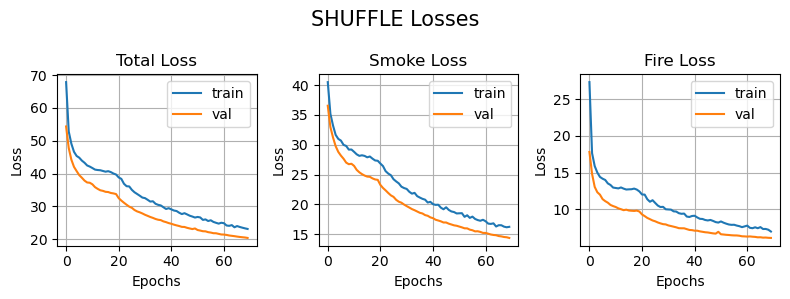

In [26]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle(MODEL + ' Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + MODEL + "_losses.png")
plt.show()